# CottonWeed15 - MobileNetV3Small

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

seed = 999
def seedEverything(seed, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        print("Running Deterministically")
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        #tf.config.threading.set_inter_op_parallelism_threads(1)
        #tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(seed, True)

2024-06-04 06:17:22.028379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 06:17:22.028487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 06:17:22.134576: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Running Deterministically


In [2]:
# ! pip install kagglehub --upgrade --q

# import kagglehub
# print(kagglehub.__version__)

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# key = user_secrets.get_secret("kaggle_token")

# kagglehub.auth.set_kaggle_credentials('reganmaharjan',key)

In [3]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [4]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/cottonweed15-downsampled/labels.csv") ## For Kaggle
data_info = data_info[['img', 'label']]
data_info

,img,label
0,351b9a52aaaf40f592557cca89a902a5__nutsedge__0.jpg,Nutsedge
1,992b7dca6928459e85aafbf945585dd0__nutsedge__7.jpg,Nutsedge
2,8803be5e86774ff1b7116d5f5a5b2727__nutsedge__0.jpg,Nutsedge
3,e1da7a5e314a41c5886b384bd69320fc__nutsedge__0.jpg,Nutsedge
4,IMG_0547.JPG,Nutsedge
...,...,...
5182,1f101adc29984ee783d36d96ad6e5b7d__purselane__2...,Purslane
5183,0001.jpg,Purslane
5184,IMG_1426.JPG,Purslane
5185,IMG_1481 (3).JPG,Purslane


In [5]:
label_counts = data_info.groupby('label').count()
label_counts.T

label,Carpetweeds,Crabgrass,Eclipta,Goosegrass,Morningglory,Nutsedge,PalmerAmaranth,Prickly Sida,Purslane,Ragweed,Sicklepod,SpottedSpurge,SpurredAnoda,Swinecress,Waterhemp
img,763,111,254,216,1115,273,689,129,450,129,240,234,61,72,451


In [6]:
# label2id = data_info['label'].unique()
# label2id = {label2id[i]:i for i in range(len(label2id))}
# id2label = {label2id[i]:i for i in label2id}
label2id = {'Nutsedge': 0, 'Sicklepod': 1, 'Morningglory': 2, 'Ragweed': 3,
            'PalmerAmaranth': 4, 'Waterhemp': 5, 'Crabgrass': 6, 'Swinecress': 7,
            'Prickly Sida': 8, 'Carpetweeds': 9, 'SpottedSpurge': 10, 'SpurredAnoda': 11,
            'Eclipta': 12, 'Goosegrass': 13, 'Purslane': 14}
id2label = {label2id[i]:i for i in label2id}
class_names = [id2label[i] for i in range(len(label2id))]

print(id2label)
print(label2id)
print(class_names)

{0: 'Nutsedge', 1: 'Sicklepod', 2: 'Morningglory', 3: 'Ragweed', 4: 'PalmerAmaranth', 5: 'Waterhemp', 6: 'Crabgrass', 7: 'Swinecress', 8: 'Prickly Sida', 9: 'Carpetweeds', 10: 'SpottedSpurge', 11: 'SpurredAnoda', 12: 'Eclipta', 13: 'Goosegrass', 14: 'Purslane'}
{'Nutsedge': 0, 'Sicklepod': 1, 'Morningglory': 2, 'Ragweed': 3, 'PalmerAmaranth': 4, 'Waterhemp': 5, 'Crabgrass': 6, 'Swinecress': 7, 'Prickly Sida': 8, 'Carpetweeds': 9, 'SpottedSpurge': 10, 'SpurredAnoda': 11, 'Eclipta': 12, 'Goosegrass': 13, 'Purslane': 14}
['Nutsedge', 'Sicklepod', 'Morningglory', 'Ragweed', 'PalmerAmaranth', 'Waterhemp', 'Crabgrass', 'Swinecress', 'Prickly Sida', 'Carpetweeds', 'SpottedSpurge', 'SpurredAnoda', 'Eclipta', 'Goosegrass', 'Purslane']


In [7]:
data_info['img'] = data_info.apply(lambda x: str(label2id[x['label']])+"_"+x['img'], axis=1)
data_info['id'] = data_info.apply(lambda x: label2id[x['label']], axis=1)

In [8]:
threshold = label_counts.quantile(0.25).iloc[0]
print(threshold)

low_data_labels = label_counts[label_counts['img'] <= threshold] ## labels with very low data
print(low_data_labels.T)
low_data_labels = list(low_data_labels.T.keys())
low_data_labels

129.0
label  Crabgrass  Prickly Sida  Ragweed  SpurredAnoda  Swinecress
img          111           129      129            61          72


['Crabgrass', 'Prickly Sida', 'Ragweed', 'SpurredAnoda', 'Swinecress']

# Splitting Data into Train:Valid:Test Splits (60:20:20)

In [9]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 3 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

skfold = StratifiedKFold(shuffle=True, random_state=seed)
kSplits = skfold.split(data_info['img'], y=data_info['label'])

for index in range(skfold.get_n_splits()):
    train_index, test_index = next(kSplits)
    if index == split_index:
        break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 4 out of 5 folds
-------------------------------------------------



In [10]:
train_data = data_info.iloc[train_index]
test_data = data_info.iloc[test_index]

print("Is There Duplicates: ", not test_data[test_data['img'].isin(train_data['img'])].empty)
print("Train Data\n-----------------------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("||\nTest Data\n-------------------------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
-----------------------
 label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            611         89      203         173           892       219   
id             611         89      203         173           892       219   

label  PalmerAmaranth  Prickly Sida  Purslane  Ragweed  Sicklepod  \
img               551           103       360      103        192   
id                551           103       360      103        192   

label  SpottedSpurge  SpurredAnoda  Swinecress  Waterhemp  
img              187            49          57        361  
id               187            49          57        361   	Total: (4150, 3)
||
Test Data
-------------------------
 label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            152         22       51          43           223        54   
id             152         22       51          43           223        54   

label  PalmerAmarant

# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [11]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['img']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    prediction = np.asarray(prediction)
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]

    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=80, #'vertical',
        # ax = ax
    )
    # fig, ax = plt.subplots(figsize=(25,5))
    # cmd.plot(ax=ax)
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model(batch[0], training=False)))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Creating Dateset ImageGenerator

In [13]:
IMG_SIZE=(256,256,3)
oversampling = 0 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/cottonweed15-downsampled/img" ## For Kaggle
base_dir = "/kaggle/working/cottonweed15" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

No OverSampling


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [14]:
train_generator, validation_generator = getDatasetGenerators(
      train_dir,
      batch_size=12,
      label_mode='categorical',
      class_names=class_names,
      image_size = IMG_SIZE[:2],
      shuffle=True,
      seed=seed,
      validation_split=0.25,
      subset="both"
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=12,
      shuffle=True,
      label_mode='categorical',
      class_names=class_names,
      image_size = IMG_SIZE[:2],
)

Found 4150 files belonging to 15 classes.
Using 3113 files for training.
Using 1037 files for validation.
Found 1037 files belonging to 15 classes.


In [15]:
from sklearn.utils import class_weight

def getWeightedClass(data, power=1, col="label"):

    class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(data_info[col]),
                                                 y=data_info[col])

    return  { label: pow(class_weights[label],power) for label in range(len(class_weights)) }

# Sample Images

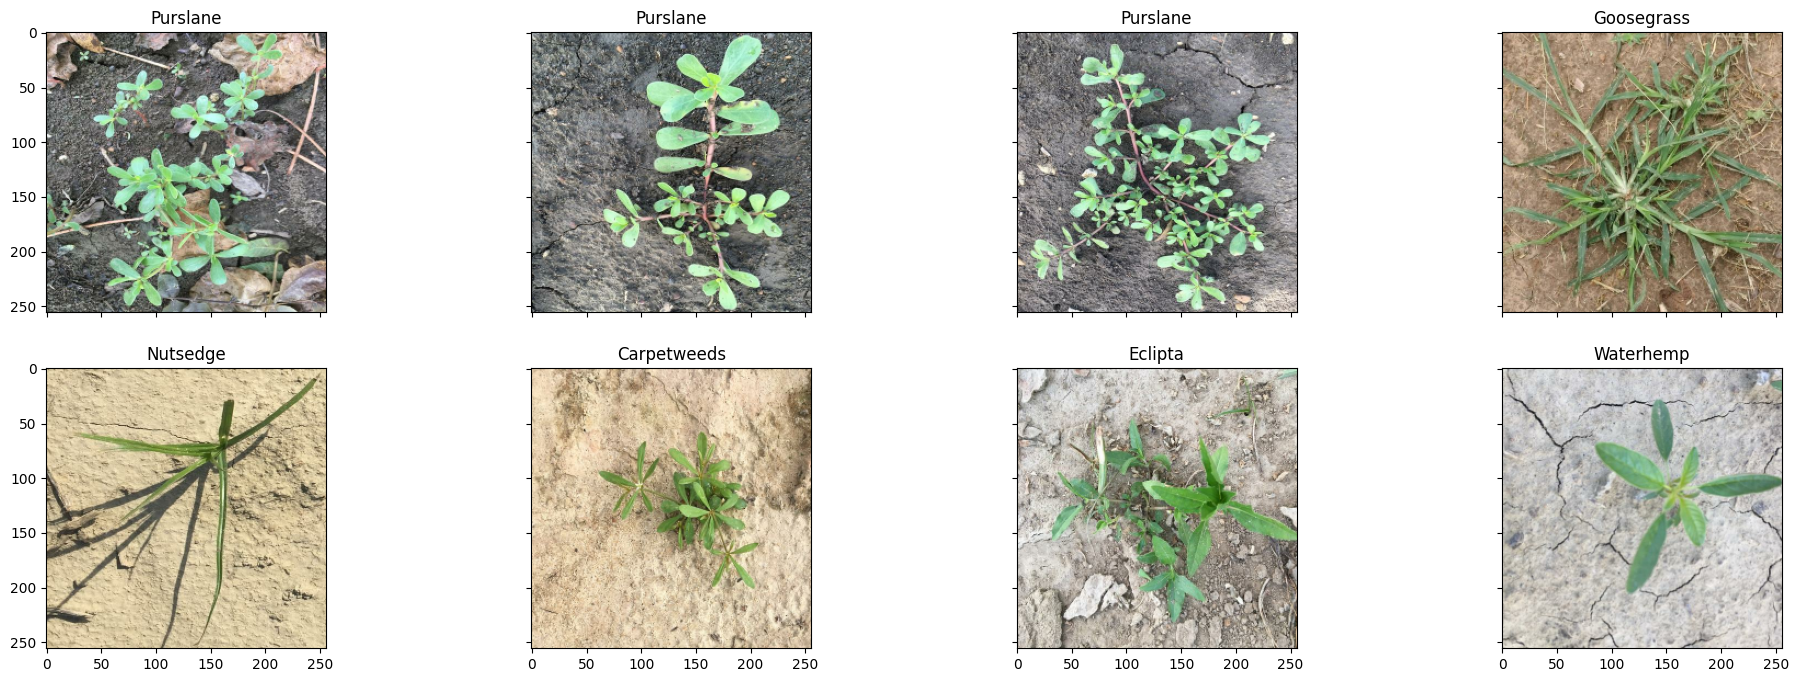

In [16]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

# Pooling Schemes

In [17]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

class SpatialMaxPooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialMaxPooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.max(x)
        x = self.reshape_backward(x)
        return x

class SpatialAveragePooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialAveragePooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.avg = tf.keras.layers.AveragePooling1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.avg(x)
        x = self.reshape_backward(x)
        return x

def AverageOfMaximums(x, max_pool_size=2, layer_num=1):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num))(_max)
    return _avg

# Transformer Encoder: Global Self Attention & Point-wise Feed Forward

In [18]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [19]:
def spatial_attention(input_feature):
    kernel_size = 5

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1

    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1

    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2

    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [20]:
def MultiFilterSpatialAttention(input_feature, kernel_size=7, num_pooled_channel=4, layer_num = 0):
    in_shape = input_feature.shape

    pool_size =  in_shape[-1] // num_pooled_channel

    channel_avg = SpatialAveragePooling2D(pool_size, padding='same', name='MFSA_SAP_L{}'.format(layer_num))(input_feature)
    channel_max = SpatialMaxPooling2D(pool_size, padding='same' , name='MFSA_SMP_L{}'.format(layer_num))(input_feature)

    concat = layers.Concatenate(axis=3, name='MFSA_ConcatChannels_L{}'.format(layer_num))([channel_avg, channel_max])

    sa_feature_x = layers.Conv2D(filters = in_shape[-1],
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    groups= num_pooled_channel,
                    use_bias=False,
                    name="MFSA_Conv_L{}".format(layer_num))(concat)

    # sa_shape = sa_feature_x.shape

    sa_feature_x =  layers.multiply([input_feature, sa_feature_x])

    # sa_feature_x = Reshape((in_shape[1], in_shape[2], -1), name="MFSA_OutBackwardReshape_L{}".format(layer_num))(sa_feature_x)
    return sa_feature_x

In [21]:
def ModifiedSpatialAttention(input_feature, kernel_size=5, num_pooled_channel=8, layer_num = 0):
    in_shape = input_feature.shape
    #pool_size =  in_shape[-1] // num_pooled_channel

    channel_avg = layers.Dense(num_pooled_channel, name="MSA_Feature_1L{}".format(layer_num))(input_feature)
    channel_max = layers.Dense(num_pooled_channel , name='MSA_Feature_2L{}'.format(layer_num))(input_feature)


    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    concat = Concatenate(axis=3)([channel_avg, channel_max])

    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

# Building MobileNet Model

In [22]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.applications import EfficientNetV2S, ConvNeXtSmall

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.3, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.3, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, name='RR_Rot'),
        layers.RandomTranslation(0.4, 0.4, seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.2, 0.2, seed=seed, name='RR_Zoom'),
        layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model

def hard_swish(x):
    relu6 = layers.ReLU(max_value=6)
    return x * (relu6(x + 3) / 6)

def MobilenetV3Base(img_size, use='S'): # use = S (small) or L (large)
    # Load the MobileNet model with weights pre-trained on ImageNet.
    if(use=='S'):
        mobilenet = MobileNetV3Small(input_shape=img_size, weights='imagenet')
    if(use=='L'):
        mobilenet = MobileNetV3Large(input_shape=img_size, weights='imagenet')
    mobilenet.trainable = True

    base_model =  keras.Model(inputs=mobilenet.layers[0].input, outputs=mobilenet.layers[-11].output, name = mobilenet.name+"_base_")
    base_model.trainable = True

    pooler = mobilenet.layers[-9]

    return base_model , pooler

def buildModel(IMG_SIZE):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model, pooler = MobilenetV3Base((224,224,3), use='S')
    base_model.trainable = True
    # out_dim = 1024 if "small" in base_model.name.lower() else 1280 if "large" in base_model.name.lower() else base_model.output.shape[-1]

    print("Base Model:", base_model.name)
    print(len(base_model.layers))
    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    x = layers.Rescaling(1./255, name='PP_Rescale')(inputs)
    x = layers.Resizing(224, 224, name='PP_Resize')(x)

    x = augment(seed)(x)
    x = base_model(x, training=True)
    
    x = ModifiedSpatialAttention(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(15, activation='softmax')(x)

    model_name = "CottonWeed15-" + base_model.name
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

    return model

In [23]:
# IMG_SIZE = (256,256,3)
# seed = 42

model = buildModel(IMG_SIZE)
model.summary()

10734624/10734624 [==============================] - 0s 0us/step
Base Model: MobilenetV3small_base_
229
Model: "CottonWeed15-MobilenetV3small_base_"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 PP_Rescale (Rescaling)      (None, 256, 256, 3)          0         ['input[0][0]']               
                                                                                                  
 PP_Resize (Resizing)        (None, 224, 224, 3)          0         ['PP_Rescale[0][0]']          
                                                                                                  
 augment_pipeline (Sequenti  (None, 224, 224, 3)          0

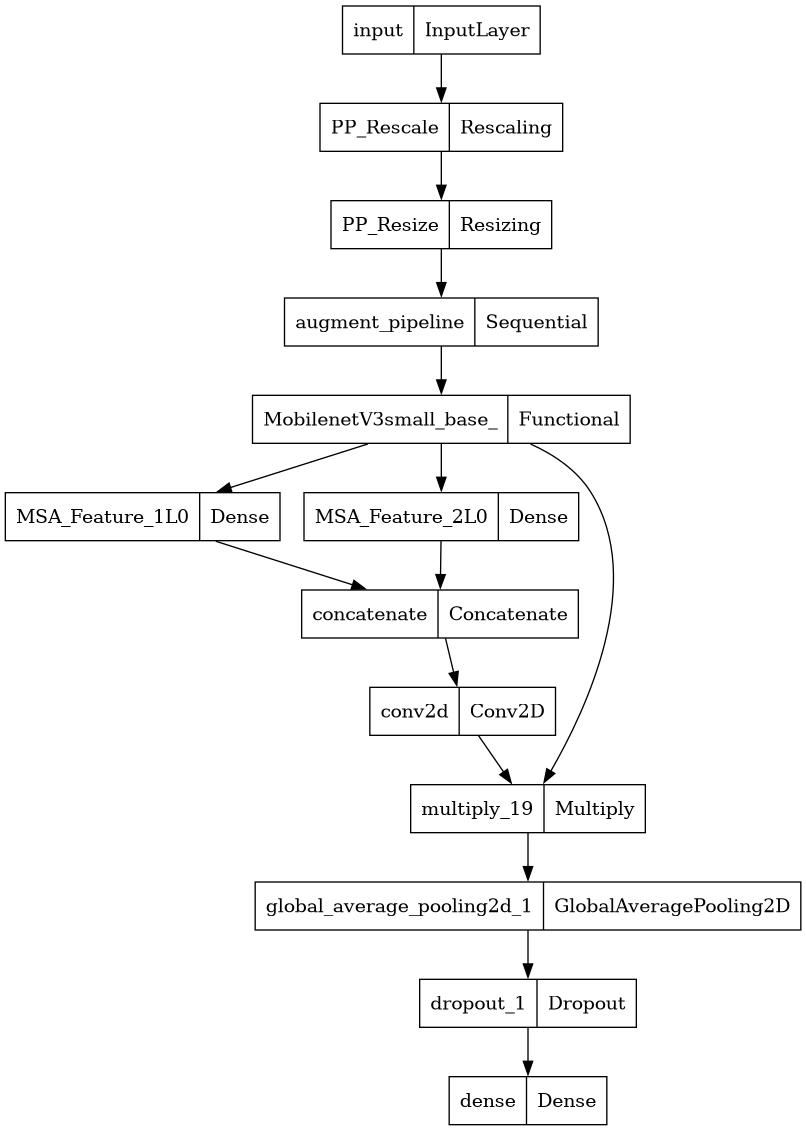

In [24]:
keras.utils.plot_model(model)

# Trial 1 - FineTuning

In [25]:
from tensorflow.keras.optimizers import Adam, AdamW

# Constant for epochs
EPOCHS = 100

pat_es = 15
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.75, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer= AdamW(learning_rate=2e-4,  weight_decay=5e-2),
          metrics=['accuracy'])

Epoch 1/100


I0000 00:00:1717481907.312147      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 [==============================] - 46s 59ms/step - loss: 2.2273 - accuracy: 0.2730 - val_loss: 1.5013 - val_accuracy: 0.5333 - lr: 2.0000e-04
Epoch 2/100
260/260 [==============================] - 14s 53ms/step - loss: 1.4700 - accuracy: 0.5509 - val_loss: 0.9125 - val_accuracy: 0.7136 - lr: 2.0000e-04
Epoch 3/100
260/260 [==============================] - 14s 53ms/step - loss: 1.1089 - accuracy: 0.6511 - val_loss: 0.7275 - val_accuracy: 0.7618 - lr: 2.0000e-04
Epoch 4/100
260/260 [==============================] - 14s 53ms/step - loss: 0.8889 - accuracy: 0.7176 - val_loss: 0.5826 - val_accuracy: 0.8139 - lr: 2.0000e-04
Epoch 5/100
260/260 [==============================] - 14s 53ms/step - loss: 0.7762 - accuracy: 0.7491 - val_loss: 0.5081 - val_accuracy: 0.8447 - lr: 2.0000e-04
Epoch 6/100
260/260 [==============================] - 14s 53ms/step - loss: 0.6900 - accuracy: 0.7761 - val_loss: 0.4903 - val_accuracy: 0.8457 - lr: 2.0000e-04
Epoch 7/100
260/260 [===================

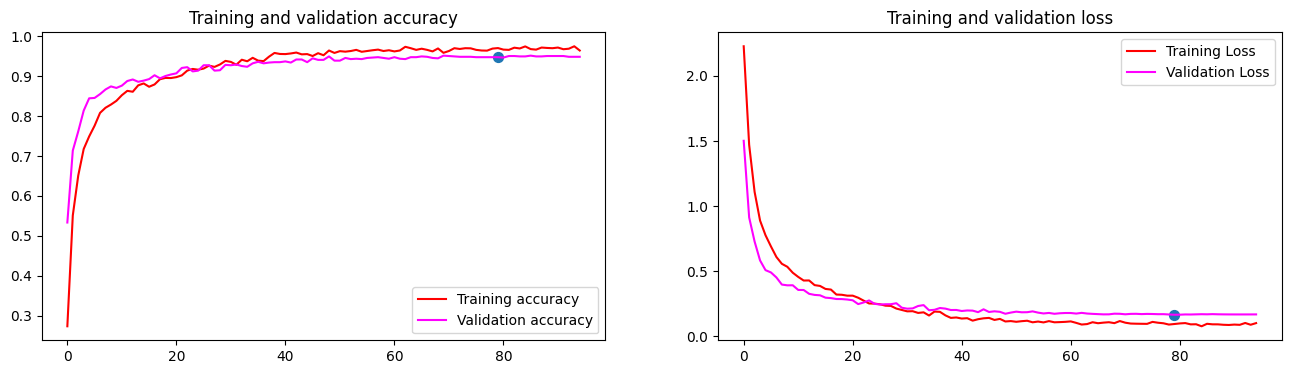

CPU times: user 43min 26s, sys: 2min 7s, total: 45min 33s
Wall time: 22min 45s


In [26]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

# Evaluation

model.evaluate
87/87 [==============================] - 1s 16ms/step - loss: 0.1656 - accuracy: 0.9479
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.98000   1.00000   0.98990        49
     Sicklepod    0.95455   0.93333   0.94382        45
  Morningglory    0.96818   0.95946   0.96380       222
       Ragweed    0.95833   1.00000   0.97872        23
PalmerAmaranth    0.92754   0.90780   0.91756       141
     Waterhemp    0.89412   0.97436   0.93252        78
     Crabgrass    0.95238   1.00000   0.97561        20
    Swinecress    0.91667   0.91667   0.91667        12
  Prickly Sida    0.80000   0.88889   0.84211        27
   Carpetweeds    0.97403   0.95541   0.96463       157
 SpottedSpurge    0.87931   0.98077   0.92727        52
  SpurredAnoda    0.81818   0.75000   0.78261        12
       Eclipta    1.00000   0.89474   0.94444        57
    Goosegrass    0.97619   0.95349   0.96471        43
      Purslane    0.97938   0.95960   0.96939        99

      accuracy                        0.94793      1037
     macro avg    0.93192 

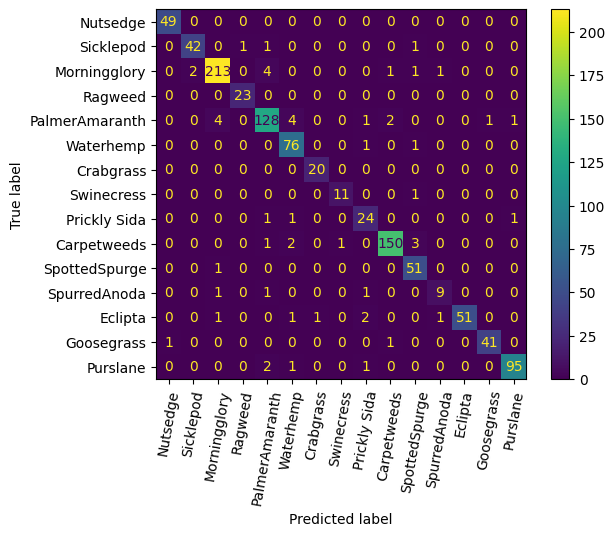

In [27]:
a, b = eval_model(model, validation_generator)

model.evaluate
87/87 [==============================] - 2s 18ms/step - loss: 0.1636 - accuracy: 0.9508
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.92857   0.96296   0.94545        54
     Sicklepod    0.91489   0.89583   0.90526        48
  Morningglory    0.96847   0.96413   0.96629       223
       Ragweed    1.00000   0.96154   0.98039        26
PalmerAmaranth    0.96970   0.92754   0.94815       138
     Waterhemp    0.87755   0.95556   0.91489        90
     Crabgrass    0.91304   0.95455   0.93333        22
    Swinecress    1.00000   1.00000   1.00000        15
  Prickly Sida    0.84000   0.80769   0.82353        26
   Carpetweeds    0.95395   0.95395   0.95395       152
 SpottedSpurge    0.97917   1.00000   0.98947        47
  SpurredAnoda    0.71429   0.83333   0.76923        12
       Eclipta    0.88235   0.88235   0.88235        51
    Goosegrass    0.97500   0.90698   0.93976        43
      Purslane    0.95506   0.94444   0.94972        90

      accuracy                        0.94214      1037
     macro avg    0.92480 

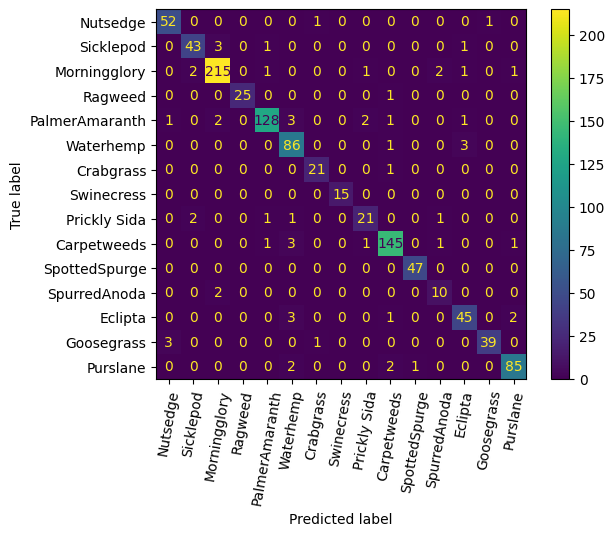

In [28]:
a, b = eval_model(model, test_generator)

# Trial 2 - Freezing Base Model

Freezing Layer MobilenetV3small_base_
Epoch 1/100
260/260 [==============================] - 13s 29ms/step - loss: 0.0650 - accuracy: 0.9785 - val_loss: 0.1157 - val_accuracy: 0.9653 - lr: 2.0000e-04
Epoch 2/100
260/260 [==============================] - 6s 24ms/step - loss: 0.0502 - accuracy: 0.9827 - val_loss: 0.1160 - val_accuracy: 0.9653 - lr: 2.0000e-04
Epoch 3/100
260/260 [==============================] - 6s 25ms/step - loss: 0.0604 - accuracy: 0.9801 - val_loss: 0.1239 - val_accuracy: 0.9653 - lr: 2.0000e-04
Epoch 4/100
260/260 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9817
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
260/260 [==============================] - 7s 26ms/step - loss: 0.0578 - accuracy: 0.9817 - val_loss: 0.1173 - val_accuracy: 0.9682 - lr: 2.0000e-04
Epoch 5/100
260/260 [==============================] - 7s 25ms/step - loss: 0.0501 - accuracy: 0.9833 - val_loss: 0.1203 - val_accuracy: 0.9682 - lr: 1.0000

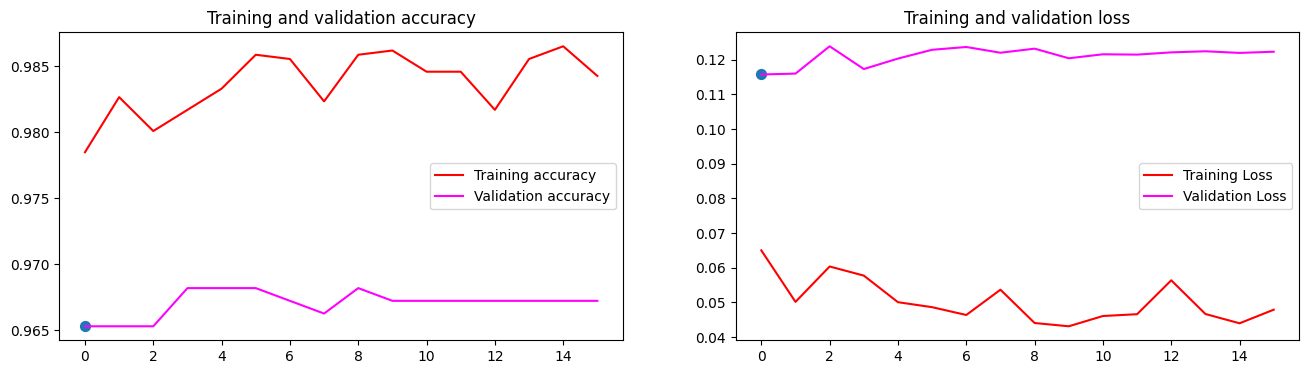

CPU times: user 5min 10s, sys: 14.7 s, total: 5min 24s
Wall time: 1min 52s


In [29]:
%%time
# weights = getWeightedClass(data_info, 1/2)
# print("Using Class-Weights",weights)
# model = skipAugment(model)
for layer in model.layers:
    if('mobilenet' in layer.name.lower()):
        print("Freezing Layer", layer.name)
        layer.trainable = False
        break

model.compile(loss='categorical_crossentropy',
    optimizer= AdamW(learning_rate=2e-4,  weight_decay=5e-2),
    metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-8)
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)

# Accuracy / Loss Plots

Total Epochs: range(0, 111)


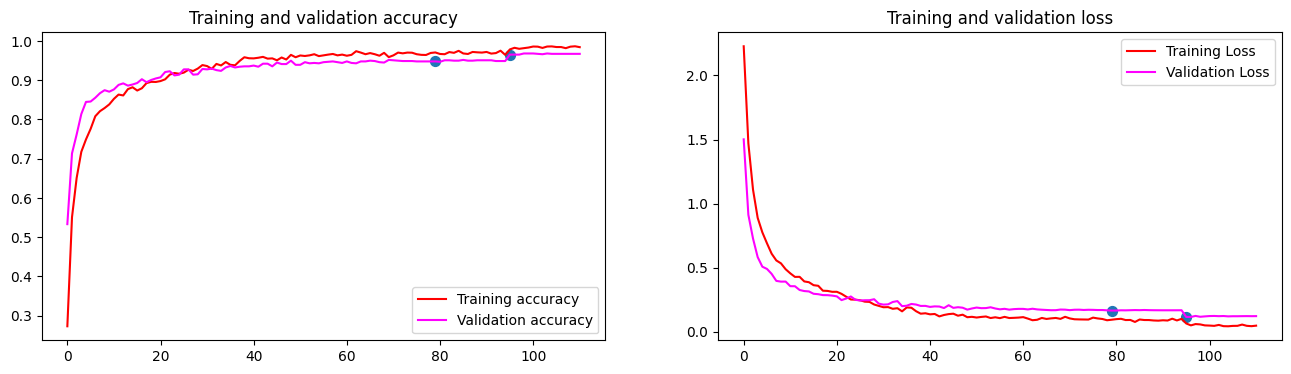

In [30]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es +=1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 95)


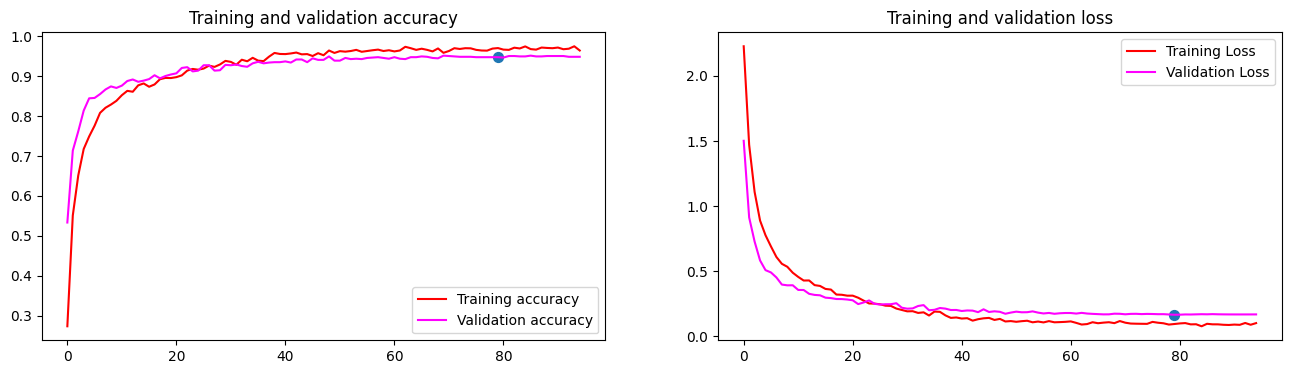

Total Epochs: range(0, 16)


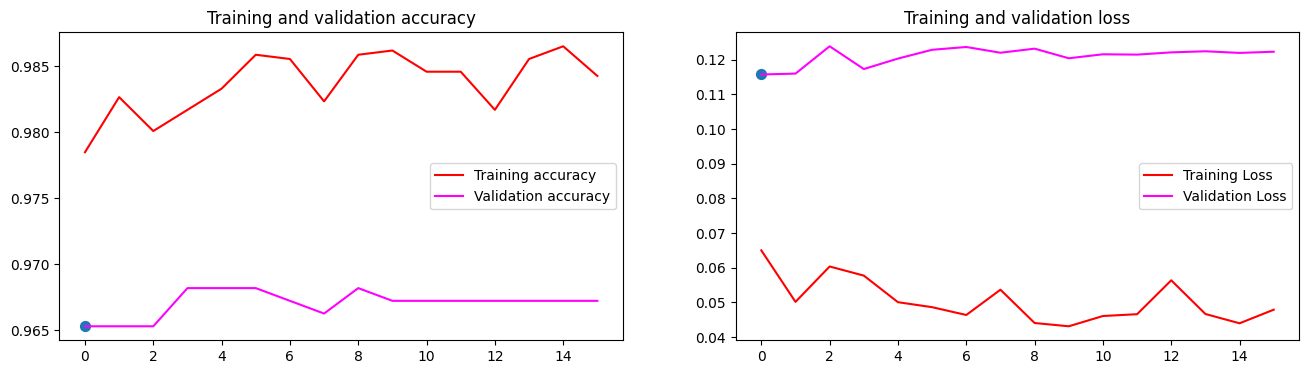

In [31]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

# Evaluation

model.evaluate
87/87 [==============================] - 1s 14ms/step - loss: 0.1157 - accuracy: 0.9653
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.98000   1.00000   0.98990        49
     Sicklepod    0.91837   1.00000   0.95745        45
  Morningglory    0.99065   0.95495   0.97248       222
       Ragweed    1.00000   1.00000   1.00000        23
PalmerAmaranth    0.99265   0.95745   0.97473       141
     Waterhemp    0.92683   0.97436   0.95000        78
     Crabgrass    1.00000   1.00000   1.00000        20
    Swinecress    1.00000   0.91667   0.95652        12
  Prickly Sida    0.85185   0.85185   0.85185        27
   Carpetweeds    0.96273   0.98726   0.97484       157
 SpottedSpurge    0.96226   0.98077   0.97143        52
  SpurredAnoda    0.80000   1.00000   0.88889        12
       Eclipta    0.94545   0.91228   0.92857        57
    Goosegrass    1.00000   0.95349   0.97619        43
      Purslane    0.96000   0.96970   0.96482        99

      accuracy                        0.96528      1037
     macro avg    0.95272 

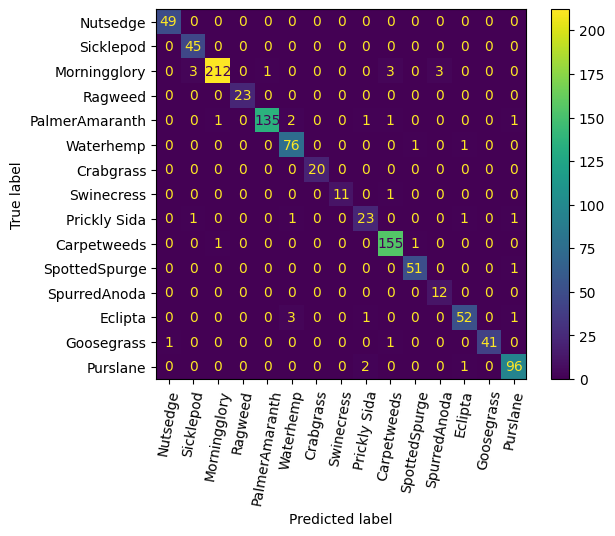

In [32]:

a, b = eval_model(model,validation_generator)

model.evaluate
87/87 [==============================] - 1s 14ms/step - loss: 0.1173 - accuracy: 0.9672
model.predict


  0%|          | 0/87 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    1.00000   1.00000   1.00000        54
     Sicklepod    0.97917   0.97917   0.97917        48
  Morningglory    0.99091   0.97758   0.98420       223
       Ragweed    1.00000   0.96154   0.98039        26
PalmerAmaranth    0.96324   0.94928   0.95620       138
     Waterhemp    0.93407   0.94444   0.93923        90
     Crabgrass    0.95652   1.00000   0.97778        22
    Swinecress    1.00000   1.00000   1.00000        15
  Prickly Sida    0.87500   0.80769   0.84000        26
   Carpetweeds    0.98026   0.98026   0.98026       152
 SpottedSpurge    0.97872   0.97872   0.97872        47
  SpurredAnoda    0.73333   0.91667   0.81481        12
       Eclipta    0.89286   0.98039   0.93458        51
    Goosegrass    1.00000   0.97674   0.98824        43
      Purslane    0.97753   0.96667   0.97207        90

      accuracy                        0.96721      1037
     macro avg    0.95077 

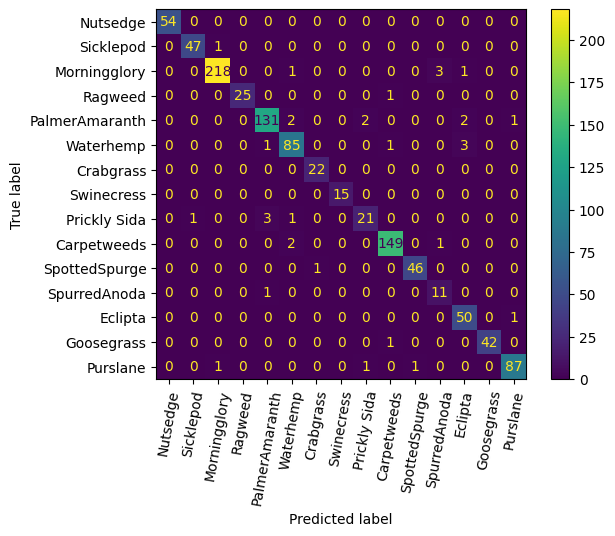

In [33]:
a, b = eval_model(model, test_generator)

In [34]:
shutil.rmtree(base_dir)